In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.\
        builder.\
        appName("covid-statut").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "512m").\
        getOrCreate()

In [2]:
print('Téléchargement du fichier des cas Covid par département ')
import requests
url = 'https://www.data.gouv.fr/fr/datasets/r/63352e38-d353-4b54-bfd1-f1b3ee1cabd7'
r = requests.get(url)

with open('/opt/workspace/data/status-dep.csv', 'wb') as f:
    f.write(r.content)
print("Téléchargement terminé")

Téléchargement du fichier des cas Covid par département 
Téléchargement terminé


In [3]:
print('Téléchargement de la liste des départements ')

url = 'https://www.data.gouv.fr/fr/datasets/r/70cef74f-70b1-495a-8500-c089229c0254'
r = requests.get(url)

with open('/opt/workspace/data/departements.csv', 'wb') as f:
    f.write(r.content)
print("Téléchargement terminé")

Téléchargement de la liste des départements 
Téléchargement terminé


In [4]:
departements = spark.read.csv(
    "/opt/workspace/data/departements.csv", header=True, mode="DROPMALFORMED"
)

In [5]:
#departements.show()

In [6]:
status_dep = spark.read.option("delimiter", ";").csv(
    "/opt/workspace/data/status-dep.csv", header=True, mode="DROPMALFORMED"
).select("dep", "jour", "hosp", "rea", "rad")

In [7]:
#status_dep.show()

In [8]:
nord = status_dep.filter((status_dep.dep == 62))

In [9]:
nord = nord.groupBy("dep","jour").agg({"hosp": "sum", "rea": "sum", "rad": "sum"})\
  .withColumnRenamed("SUM(hosp)", "hosp") \
  .withColumnRenamed("SUM(rea)", "rea") \
  .withColumnRenamed("SUM(rad)", "rad")


In [10]:
full_info = nord.join(departements, departements.code_departement == nord.dep).select("jour", "nom_departement", "hosp", "rad", "rea")

In [11]:
full_info = full_info.orderBy('jour', ascending=True)

In [12]:
#full_info.show()

In [13]:
full_info.write.format("csv").option("header", "false").mode("append").save("/opt/workspace/data/cas-covid")
#full_info.write.format("csv").option("header", "false").mode("append").save("hdfs://namenode:8020/user/admin/covid.csv")


In [21]:
#install pandas and matplotlib if not installed
!pip install pandas matplotlib

     |████████████████████████████████| 11.6 MB 4.2 MB/s eta 0:00:01    |█▋                              | 583 kB 4.2 MB/s eta 0:00:03     |███████▋                        | 2.8 MB 4.2 MB/s eta 0:00:03     |█████████████▌                  | 4.9 MB 4.2 MB/s eta 0:00:02     |██████████████████              | 6.5 MB 4.2 MB/s eta 0:00:02     |█████████████████████▏          | 7.7 MB 4.2 MB/s eta 0:00:01     |████████████████████████▌       | 8.9 MB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 14.4 MB/s eta 0:00:01     |█████████▉                      | 348 kB 14.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 42.8 MB/s eta 0:00:01     |████████████████████████████████| 2.2 MB 42.8 MB/s 


In [24]:
pandas_covid = full_info.toPandas()

In [25]:
pandas_covid.set_index(['nom_departement','jour'], inplace=True);

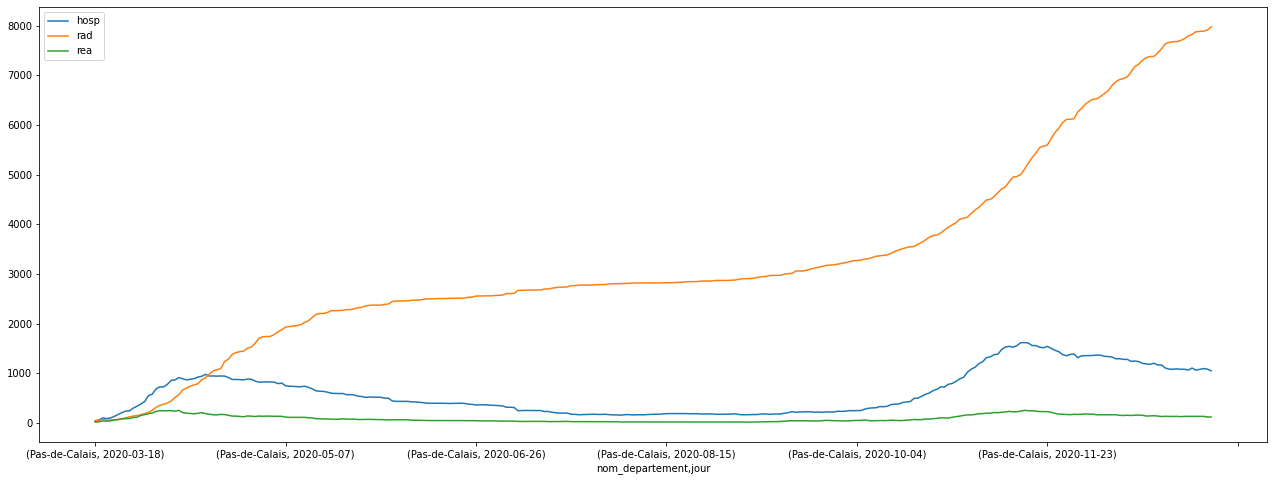

In [26]:
pandas_covid.plot(kind='line',figsize=(22,8));